In [1]:
!pip install einops
import numpy as np
import random
import scipy 

import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import tensorflow.keras as keras
import tensorflow as tf

%matplotlib inline
import math
from inspect import isfunction
from functools import partial
import pandas as pd
import h5py
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

In [2]:
# Helper Functions:
"https://huggingface.co/blog/annotated-diffusion"
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

In [3]:
class SEBlock(nn.Module):
    def __init__(self,dim_in, units, bottleneck_units):
        super().__init__()
        self.units = units
        
        # Define the SEBlock Layers:
        self.Linear = nn.LazyLinear(units)
        self.Global_Average_Pool = nn.AdaptiveAvgPool2d(dim_in)
        self.Bottleneck = nn.LazyLinear(bottleneck_units)
        self.Sigmoid = nn.Sigmoid()
        self.SELU = nn.SELU()
        
    def forward(self, x):
        x = self.Global_Average_Pool(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.Bottleneck(x)
        x = self.SELU(x)
        x = self.Linear(x)
        x = self.Sigmoid(x)
        x = x.view(-1,self.units,1,1)
        return x

In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    "https://huggingface.co/blog/annotated-diffusion"
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [5]:
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) / (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


In [6]:
class Conv_Block(nn.Module):
    "https://huggingface.co/blog/annotated-diffusion"
    def __init__(self, dim, filters, groups = 8):
        super().__init__()
        self.Convolution_Layer = WeightStandardizedConv2d(dim, filters, (3,3), padding = 1)
        self.normalisation =  nn.GroupNorm(groups, filters)
        self.activation = nn.SiLU()
        
    def forward(self, x, scale_shift=None):
        # Convolution Layers
        x = self.Convolution_Layer(x)
        x = self.normalisation(x)
        
        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        
        x = self.activation(x)
        
        return x

In [7]:
class SE_Resnet_Block(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    def __init__(self, dim, dim_out, bottleneck, *, time_emb_dim = None, groups = 8):
        super().__init__()
        
        self.mlp = (
        nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
        if exists(time_emb_dim)
        else None
        )
        self.SE_block = SEBlock(dim_out, dim_out, bottleneck) 
        self.CBlock_1 = Conv_Block(dim, dim_out, groups)
        self.CBlock_2 = Conv_Block(dim_out, dim_out, groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
        
    def forward(self, x, time_emb = None):
        scale_shift = None
        scaled = False
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.CBlock_1(x, scale_shift = scale_shift)
        h = self.CBlock_2(h)
        y = self.SE_block(h)
        h = h * y
        return h + self.res_conv(x)

In [45]:
class Attention(nn.Module):
    "https://huggingface.co/blog/annotated-diffusion"
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

    

In [46]:
class PreNorm(nn.Module):
    "https://huggingface.co/blog/annotated-diffusion"
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [47]:
class Unet(nn.Module):
    "https://huggingface.co/blog/annotated-diffusion"
    def __init__(self, 
                 dim, init_dim = None, out_dim = None,
                 dim_multiples = (1,2,4,8),
                 channels = 3,
                 self_condition = False,
                 resnet_block_groups = 4,
                 bottleneck = 4,
                ):
        super().__init__()
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)
        
        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding = 0)
        
        dims = [init_dim, *map(lambda m: dim*m, dim_multiples)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        block_class = partial(SE_Resnet_Block, groups = resnet_block_groups)
        
        # Time Embeddings
        time_dim = dim*4
        
        self.time_mlp = nn.Sequential(
        SinusoidalPositionEmbeddings(dim),
        nn.Linear(dim, time_dim),
        nn.GELU(),
        nn.Linear(time_dim, time_dim)
        )
        
        # Layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)
        
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_class(dim_in, dim_in, bottleneck, time_emb_dim=time_dim),
                        block_class(dim_in, dim_in, bottleneck, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )
            
        mid_dim = dims[-1]
        self.mid_block1 = block_class(mid_dim, mid_dim, bottleneck, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_class(mid_dim, mid_dim, bottleneck, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_class(dim_out + dim_in, dim_out, bottleneck, time_emb_dim=time_dim),
                        block_class(dim_out + dim_in, dim_out, bottleneck, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_class(dim * 2, dim, bottleneck, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)
        
    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [48]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

In [49]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [50]:
timesteps = 300

# define beta schedule
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [51]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [52]:
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

In [53]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  #noisy_image = reverse_transform(x_noisy)
  noisy_image = x_noisy

  return noisy_image

In [54]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [55]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [56]:
# load "info" as pandas dataframe
data_path = r"C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\Machine Learning Personal Projects\Cyclone Imaging\Cyclone h5 Dataset\Cyclone_Images.h5"
#data_info = pd.read_hdf(data_path, key="info", mode='r')

# load "matrix" as numpy ndarray, this could take longer times
with h5py.File(data_path, 'r') as hf:
    Cyclone_Images = hf['Images'][:]

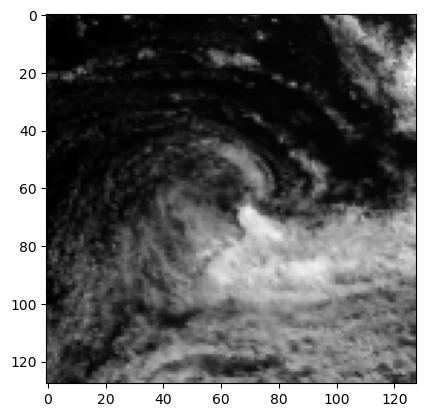

In [57]:
plt.imshow(Cyclone_Images[25, :, :, 2], cmap = "gray")

In [58]:
from skimage.transform import resize
Cyclone_Images = np.array([resize(x, (32,32)) for x in Cyclone_Images])

c:\Users\kdarn\anaconda3\envs\NeuralNets\Lib\site-packages\skimage\transform\_warps.py:674: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
c:\Users\kdarn\anaconda3\envs\NeuralNets\Lib\site-packages\skimage\transform\_warps.py:678: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


In [59]:
mask = np.isnan(Cyclone_Images).any(axis = (1,2))
np.unique(mask)

array([False,  True])

In [60]:
Cyclone_Images = torch.Tensor(Cyclone_Images)
Cyclone_Images = 2*(Cyclone_Images)/255.0 - 1

In [61]:
from torchvision import transforms
from torch.utils.data import DataLoader

batch_size = 64
# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

# create dataloader
dataloader = DataLoader(np.transpose(Cyclone_Images[:32*4,:,:,2].reshape(-1,32,32,1), (0,3,1,2)), batch_size=batch_size, shuffle=True)

In [62]:
Cyclone_Images[:,:,:,2].reshape(-1,32,32,1).shape

torch.Size([21076, 32, 32, 1])

In [63]:
images = next(iter(dataloader))
images.max()

tensor(0.9780)

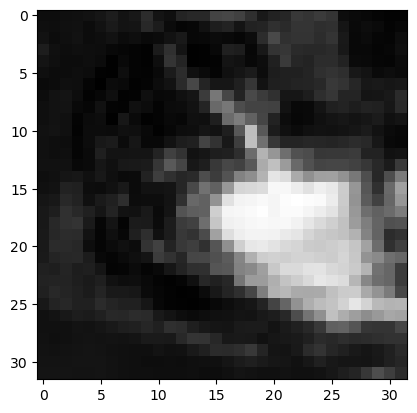

In [64]:
plt.imshow(images[10, 0, :, :], cmap = "gray")

In [65]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [66]:
images[0, 0, :, :].reshape(1,32,32).shape

torch.Size([1, 32, 32])

In [67]:
image = images[10,0,:,:]

In [68]:
plot([get_noisy_image(images[10, 0, :, :], torch.tensor([t])) for t in [0,50,100,150,250,299]], with_orig= True, cmap = "gray")

In [69]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [70]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [71]:
image_size = 64
channels = 1
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_multiples=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

c:\Users\kdarn\anaconda3\envs\NeuralNets\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [1]:
from torchvision.utils import save_image

epochs = 6

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch.shape[0]
      batch = batch.to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")


      print("Loss:", loss.item())

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
      optimizer.step()
      """
      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
      """

NameError: name 'dataloader' is not defined